In [ ]:
import pandas as pd

# Load the uploaded CSV file to examine its contents
file_path = '/content/restaurant_orders_new.csv'
data = pd.read_csv(file_path)

# Display the first few rows and get general info about the data
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1097 non-null   object
 1   day_of_week  1097 non-null   int64 
 2   month        1097 non-null   int64 
 3   orders       1097 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 34.4+ KB


(         date  day_of_week  month  orders
 0  2023-01-01            6      1     435
 1  2023-01-02            0      1     375
 2  2023-01-03            1      1     279
 3  2023-01-04            2      1     434
 4  2023-01-05            3      1     299,
 None)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0870 - val_loss: 0.0185
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0213 - val_loss: 0.0183
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0229 - val_loss: 0.0182
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0228 - val_loss: 0.0182
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0202 - val_loss: 0.0186
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0192 - val_loss: 0.0186
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0196 - val_loss: 0.0181
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0195 - val_loss: 0.0188
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0205 - val_loss: 0.0181
Epoch 10/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0215 - val_loss: 0.0180
Epoch 11/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 - val_loss: 0.0185
Epoch 12/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0189 - v

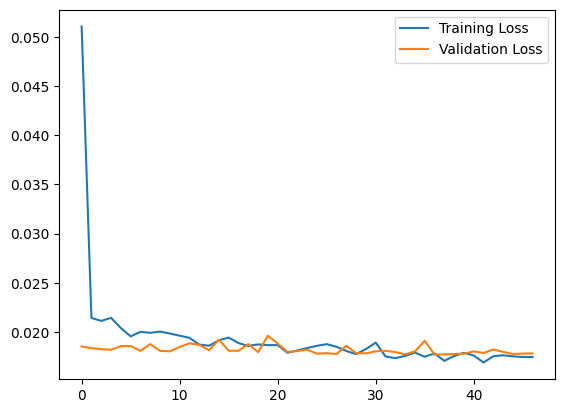

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Convert date to datetime format and set as index for easier handling of time series
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Scaling the orders for better performance with LSTM
scaler = MinMaxScaler()
data['orders'] = scaler.fit_transform(data[['orders']])

# Prepare data for supervised learning by creating sequences for the LSTM model
def create_sequences(data, seq_length=7):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Using the 'orders' column as input sequence
seq_length = 7  # Use the past 7 days to predict the next day's sales
orders_data = data['orders'].values
X, y = create_sequences(orders_data, seq_length)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


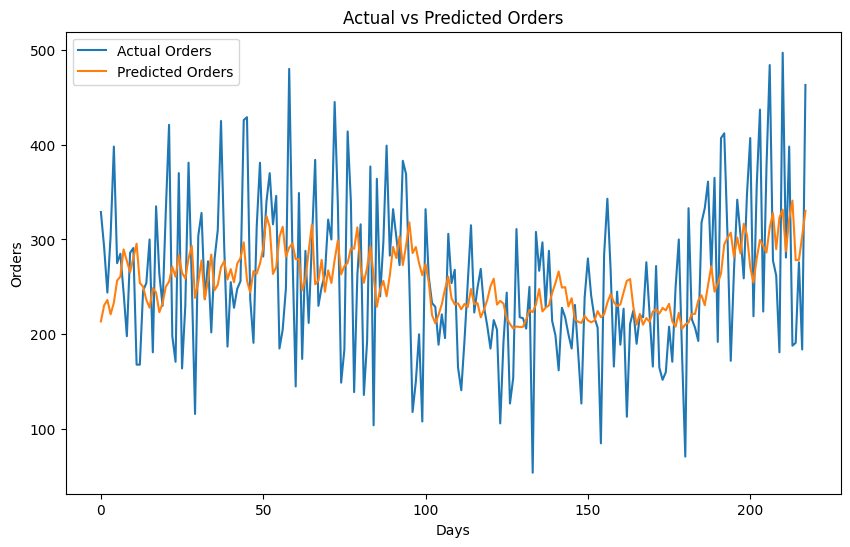

In [ ]:
# Make predictions for the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted orders
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Orders')
plt.plot(y_pred_rescaled, label='Predicted Orders')
plt.xlabel('Days')
plt.ylabel('Orders')
plt.legend()
plt.title('Actual vs Predicted Orders')
plt.show()

In [ ]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6
0,0.675127,0.573604,0.411168,0.673435,0.445008,0.377327,0.571912
1,0.573604,0.411168,0.673435,0.445008,0.377327,0.571912,0.304569
2,0.411168,0.673435,0.445008,0.377327,0.571912,0.304569,0.324873
3,0.673435,0.445008,0.377327,0.571912,0.304569,0.324873,0.304569
4,0.445008,0.377327,0.571912,0.304569,0.324873,0.304569,0.624365


In [ ]:
y_pred_rescaled = pd.DataFrame(y_pred_rescaled)
y_pred_rescaled.head()

,0
0,213.573318
1,230.484482
2,236.167892
3,221.102158
4,233.328018


In [ ]:
y_test_rescaled = pd.DataFrame(y_test_rescaled)
y_test_rescaled.head()

,0
0,329.0
1,292.0
2,244.0
3,304.0
4,398.0


Mean Squared Error: 0.018220963410581


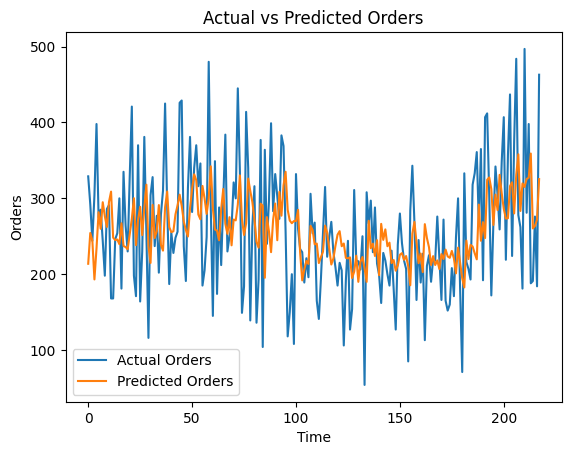

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = 'restaurant_orders_new.csv'  # Update path if needed
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Scaling orders to keep features consistent with prior setup
scaler = MinMaxScaler()
data['orders'] = scaler.fit_transform(data[['orders']])

# Create sequences for supervised learning
def create_sequences(data, seq_length=7):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Use past 7 days to predict the next day’s orders
seq_length = 7
orders_data = data['orders'].values
X, y = create_sequences(orders_data, seq_length)

# Flatten sequences for use with linear regression
X = X.reshape(X.shape[0], -1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot actual vs predicted orders
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Orders')
plt.plot(scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Predicted Orders')
plt.legend()
plt.title("Actual vs Predicted Orders")
plt.xlabel("Time")
plt.ylabel("Orders")
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 12431.642767978108


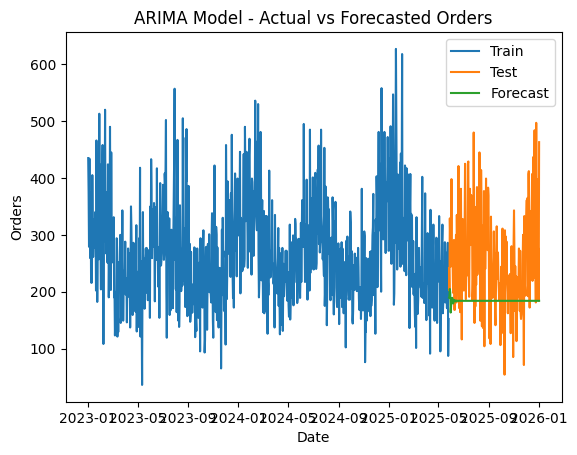

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load and preprocess data
file_path = 'restaurant_orders_new.csv'  # Update path if needed
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Extract orders as a time series
orders_data = data['orders']

# Split data into training and testing sets (e.g., last 20% for testing)
train_size = int(len(orders_data) * 0.8)
train, test = orders_data[:train_size], orders_data[train_size:]

# ARIMA model configuration (p, d, q)
# These values can be tuned, but (5,1,0) is a common initial choice for ARIMA
p, d, q = 5, 1, 0
model = ARIMA(train, order=(p, d, q))
fitted_model = model.fit()

# Forecast for the length of the test set
forecast = fitted_model.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
print("Mean Squared Error:", mse)

# Plot actual vs predicted orders
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title("ARIMA Model - Actual vs Forecasted Orders")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()
